In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

DATA_DIR = '../data'
MODEL_DIR = '../models'

STOCK_TICKER_TO_TEST = 'AAPL'
SUBSET_TO_TEST = 'Tum_Ozellikler'
K_TO_TEST = 5
WINDOW_TO_TEST = 3

DATA_FILE_TO_TEST = os.path.join(DATA_DIR, f"{STOCK_TICKER_TO_TEST}.csv")

MODEL_FILE_TO_TEST = os.path.join(MODEL_DIR, f"xgb_{STOCK_TICKER_TO_TEST}_subset-{SUBSET_TO_TEST}_k{K_TO_TEST}_w{WINDOW_TO_TEST}.joblib")

print(f"Test edilecek model dosyası: {MODEL_FILE_TO_TEST}")
print(f"Kullanılacak veri dosyası: {DATA_FILE_TO_TEST}")

Test edilecek model dosyası: ../models/xgb_AAPL_subset-Tum_Ozellikler_k5_w3.joblib
Kullanılacak veri dosyası: ../data/AAPL.csv


In [2]:
def load_and_clean_data(file_path):
    try:
        df = pd.read_csv(file_path)
        stock_ticker = os.path.basename(file_path).split('.')[0]
        required_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        if not all(col in df.columns for col in required_cols): return None, None
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df.dropna(how='any', inplace=True)
        df = df[(df[['Open', 'High', 'Low', 'Close', 'Volume']] > 0).all(axis=1)]
        return df, stock_ticker
    except Exception: return None, None

def feature_engineering(df):
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
    delta = df['Close'].diff(1); gain = delta.where(delta > 0, 0); loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean(); avg_loss = loss.rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + (avg_gain / avg_loss)))
    high_low = df['High'] - df['Low']; high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    df['ATR'] = np.max(ranges, axis=1).rolling(window=14).mean()
    df['Target'] = (df['Close'] > df['Open']).astype(int)
    df['Target'] = df['Target'].shift(-1)
    df.dropna(inplace=True)
    df['Target'] = df['Target'].astype(int)
    return df

def create_windowed_dataset(X, y, window_size=5):
    X_windowed, y_windowed = [], []
    for i in range(window_size, len(X)):
        features = X.iloc[i-window_size:i].values.flatten()
        X_windowed.append(features)
        y_windowed.append(y.iloc[i])
    return np.array(X_windowed), np.array(y_windowed)

In [3]:
df_full, stock_ticker = load_and_clean_data(DATA_FILE_TO_TEST)
if df_full is None:
    print("Veri yüklenemedi, işlem durduruldu.")
else:
    df_featured = feature_engineering(df_full)
    print(f"{stock_ticker} için veri başarıyla yüklendi ve işlendi.")

try:
    model = joblib.load(MODEL_FILE_TO_TEST)
    print("\nModel başarıyla yüklendi:")
    print(model)
except FileNotFoundError:
    print(f"\nHATA: Model dosyası bulunamadı! Lütfen yolu kontrol edin: {MODEL_FILE_TO_TEST}")
    model = None

AAPL için veri başarıyla yüklendi ve işlendi.

Model başarıyla yüklendi:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)


In [4]:
if model and df_featured is not None:
    X_full = df_featured.drop('Target', axis=1)
    y_full = df_featured['Target']
    
    feature_subsets = {
        'Tum_Ozellikler': X_full.columns.tolist(),
        'Sadece_Teknik_Indikatorler': ['EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'ATR'],
        'Sadece_EMA_Trend': ['EMA_10', 'EMA_20', 'EMA_50'],
        'Momentum_ve_Volatilite': ['RSI', 'ATR'],
    }
    subset_columns = feature_subsets.get(SUBSET_TO_TEST)
    X_subset = X_full[subset_columns]
    
    selector = SelectKBest(f_classif, k=K_TO_TEST).fit(X_subset, y_full)
    X_selected = X_subset[X_subset.columns[selector.get_support()]]
    X_windowed, y_windowed = create_windowed_dataset(X_selected, y_full, window_size=WINDOW_TO_TEST)

    split_ratio = 0.8
    split_index = int(len(X_windowed) * split_ratio)
    X_train_w, X_test_w = X_windowed[:split_index], X_windowed[split_index:]
    y_train_w, y_test_w = y_windowed[:split_index], y_windowed[split_index:]

    scaler = StandardScaler().fit(X_train_w)
    X_test_scaled = scaler.transform(X_test_w)

    print("Test verisi başarıyla hazırlandı.")
    print(f"Test edilecek örnek sayısı: {X_test_scaled.shape[0]}")

Test verisi başarıyla hazırlandı.
Test edilecek örnek sayısı: 1979


In [5]:
print("DEBUG")


if 'model' in locals() and model is not None:
    print(f"loaded: {model}")
    print(f"expected: {model.n_features_in_}")
else:
    print("err")

print("-" * 50)

if 'X_test_scaled' in locals():
    print(f"Test data : X_test_scaled")
    print(f"Test data shape: {X_test_scaled.shape}")
    print(f"Test data feature: {X_test_scaled.shape[1]}")
else:
    print("err")


DEBUG
loaded: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)
expected: 15
--------------------------------------------------
Test data : X_test_scaled
Test data shape: (1979, 15)
Test data feature: 15


--- MODEL DEĞERLENDİRME SONUÇLARI ---

Modelin Test Verisi Üzerindeki Doğruluğu: 0.4795

Sınıflandırma Raporu:
              precision    recall  f1-score   support

   Düşüş (0)       0.48      0.88      0.62       952
Yükseliş (1)       0.49      0.10      0.17      1027

    accuracy                           0.48      1979
   macro avg       0.49      0.49      0.40      1979
weighted avg       0.49      0.48      0.39      1979

Karmaşıklık Matrisi:


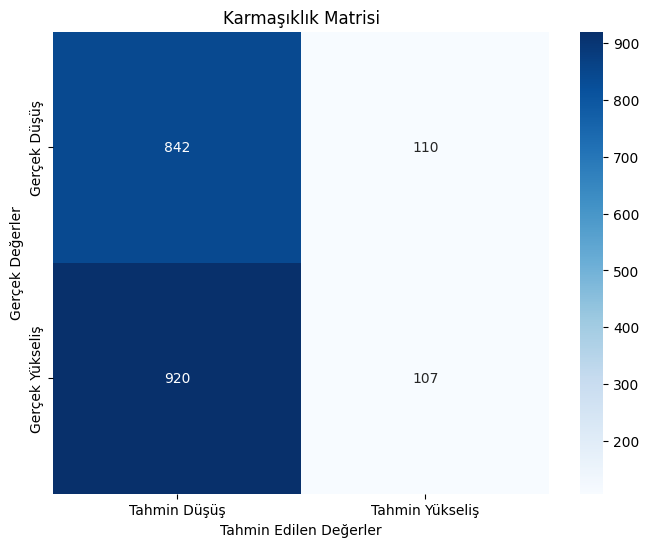

In [6]:
if model and 'X_test_scaled' in locals():
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test_w, y_pred)
    print(f"--- MODEL DEĞERLENDİRME SONUÇLARI ---\n")
    print(f"Modelin Test Verisi Üzerindeki Doğruluğu: {accuracy:.4f}\n")
    
    print("Sınıflandırma Raporu:")
    print(classification_report(y_test_w, y_pred, target_names=['Düşüş (0)', 'Yükseliş (1)']))
    
    print("Karmaşıklık Matrisi:")
    cm = confusion_matrix(y_test_w, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Tahmin Düşüş', 'Tahmin Yükseliş'],
                yticklabels=['Gerçek Düşüş', 'Gerçek Yükseliş'])
    plt.title('Karmaşıklık Matrisi')
    plt.ylabel('Gerçek Değerler')
    plt.xlabel('Tahmin Edilen Değerler')
    plt.show()